In [79]:
%matplotlib inline
from tqdm import tqdm,trange
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
import math
import statistics as stat
from matplotlib import pyplot as plt
print("OpenCV Version : %s " % cv2.__version__)

OpenCV Version : 3.4.0 


In [70]:
pupil_area = []
pupil_center = []

# Load the video. 0 stays for binary (grayscaled, 1-channel) image loading.
cap = cv2.VideoCapture('toy_data/data.mj2',0)
length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
# Test for crop. Will be used later in code to crop the eye region.
selection_set = False

# Start the processing. The while loop iterates over all the frames in given data set one by one.
for i in trange(length):
    # Load original frames.
    _, frame = cap.read()
    
    # Select the eye region on the first frame.
    if not selection_set:
        r = cv2.selectROI(frame)
        selection_set = True
        cv2.destroyAllWindows()
    
    
        
    # Crop the frame according to region selected in the beginning.
    cropped = frame[r[1]:(r[1]+r[3]),r[0]:(r[0]+r[2])]
    
    ## Blur the frame. Arguments are handpicked.
    blurred = cv2.GaussianBlur(cropped,(13,13),5)
    
    ## Get rid of most of lighter coloured pixels on the image. Arguments are handpicked.
    _, thresholded = cv2.threshold(blurred,70,255,cv2.THRESH_BINARY)
    
    ## Detect the edges. Arguments are handpicked.
    edged = cv2.Canny(thresholded,100,200)
    
    try:
        _, contours, _ = cv2.findContours(edged, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        
        # Ellipse could only be fitted into a contour if it has at least 5 points. Thats why >4.
        contours = [contour for contour in contours if len(contour)>4]
        
        # Fit an ellipse into previously filtered contours.
        ellipses = [cv2.fitEllipse(contour) for contour in contours]
        
        # Compute perimeter/area ratio. If area is 0, assign arbitrary high value.
        # Thus, we are defining the most "circular" out of all the fitted ellipses.
        loss = np.asarray([cv2.arcLength(cnt,True)/cv2.contourArea(cnt) if cv2.contourArea(cnt)!=0 else 100500 for cnt in contours])
        
        # Find the index of the minimal element of these perimeter/area ratios.
        target_id = np.argmin(loss)
        
        # Draw an ellipse on the cropped image.
        ellipsed = cv2.ellipse(cropped.copy(),ellipses[target_id],(0,255,0),2)
        
        # Plot lots of sexy rat's eyes.
        result = np.vstack([np.hstack([cropped,blurred]),np.hstack([thresholded,ellipsed])])
        
        # Calculate area of fitted and position of it's center with respect to original image
        center, axes, _ = ellipses[target_id]
        ellarea = math.pi / 4 * axes[0] * axes[1]
        
        pupil_area.extend([ellarea])
        pupil_center.extend([(center[0]+r[0],center[1]+r[3])])
        
        # Temporary solution for the case of eye's blink.
    except:
        error = cv2.putText(cropped.copy(),"Achtung!", (int(cropped.shape[0]/2),int(cropped.shape[1]/2)), cv2.FONT_HERSHEY_SIMPLEX, 2, 255)

        result = np.vstack([np.hstack([cropped,blurred]),np.hstack([thresholded,error])])
        
        pupil_area.extend([0])
        pupil_center.extend([(0,0)])
        
    # Pop-up all four steps 
    # cv2.imshow('result',result)
    
    # To stop video press q
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


  2%|█▏                                                                          | 1379/90046 [00:08<08:48, 167.63it/s]
Exception in thread Thread-8:
Traceback (most recent call last):
  File "C:\Users\dvasilev\Anaconda3\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\dvasilev\Anaconda3\lib\site-packages\tqdm\_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "C:\Users\dvasilev\Anaconda3\lib\_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



100%|███████████████████████████████████████████████████████████████████████████| 90046/90046 [06:47<00:00, 221.14it/s]


In [69]:
type(frame)

NoneType

In [72]:
np.save("pupil_area",pupil_area)
np.save("pupil_center",pupil_center)

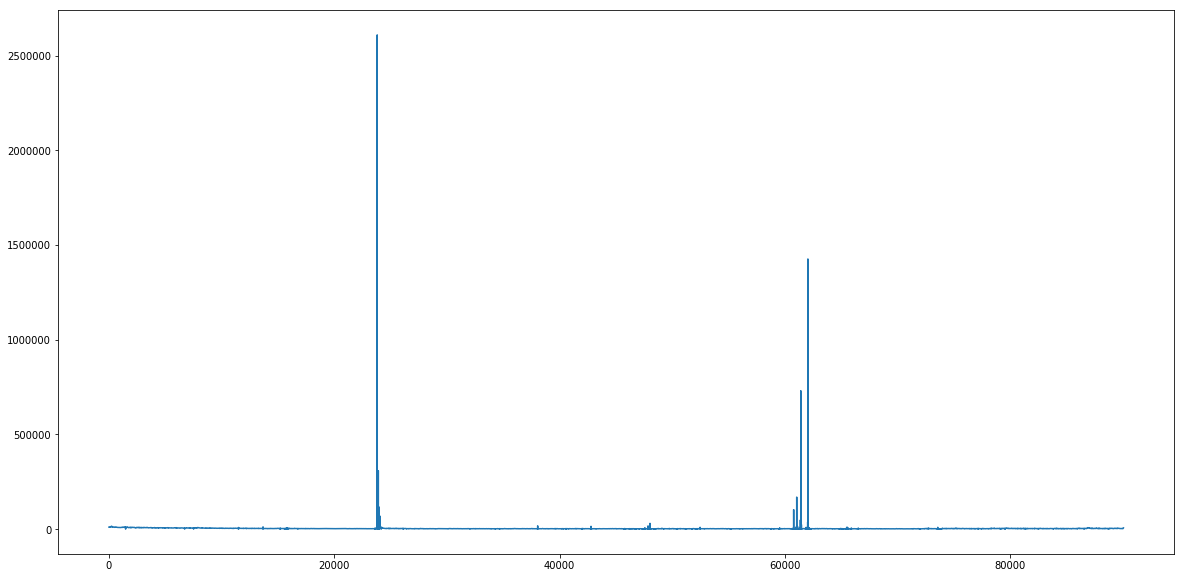

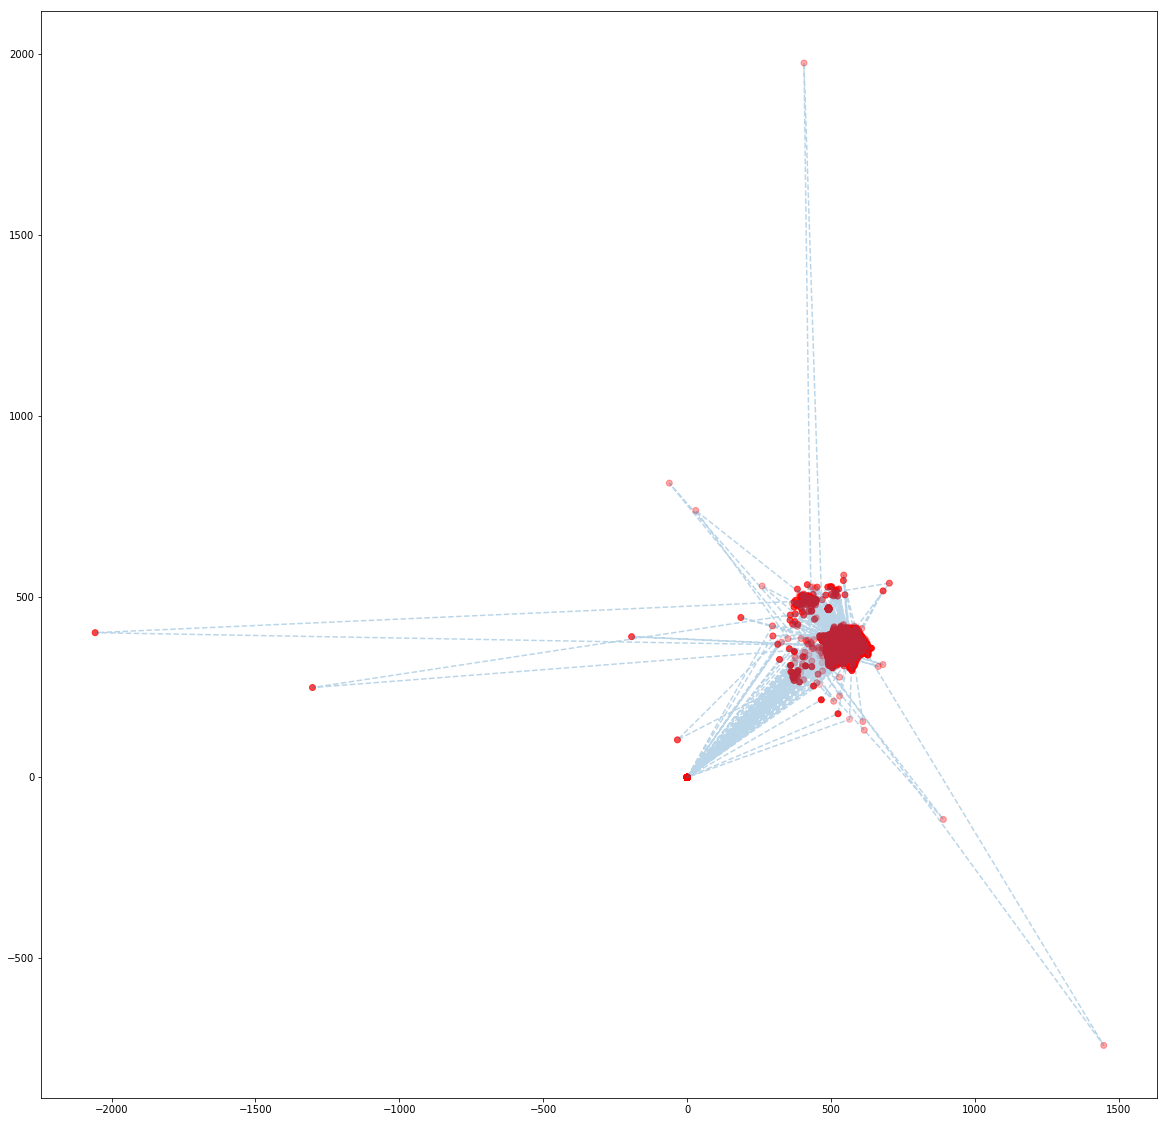

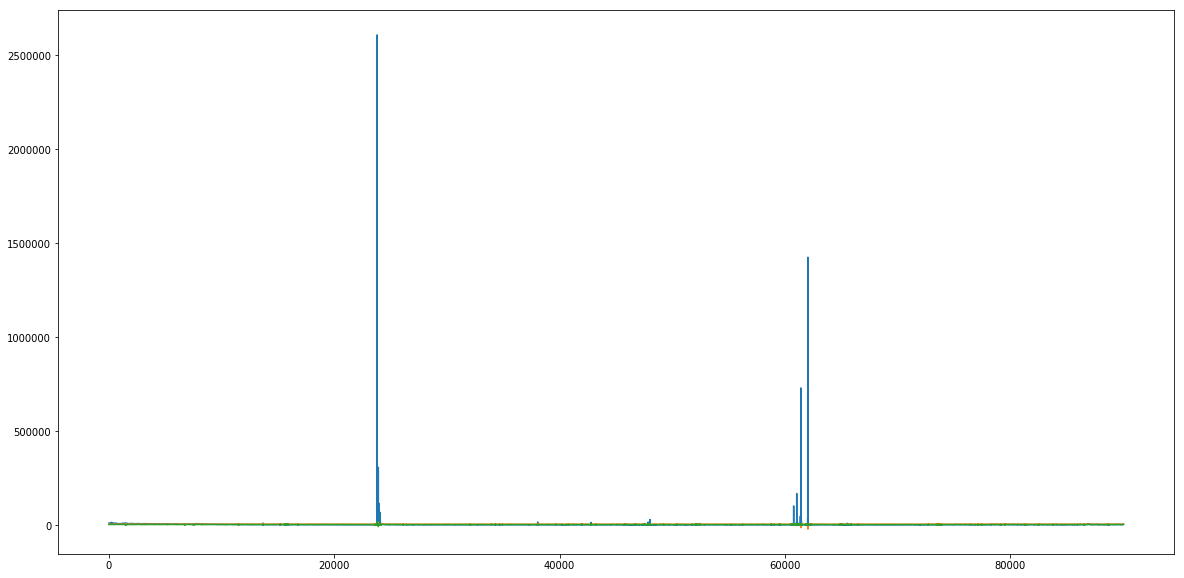

In [73]:
#pupil_area = np.load('pupil_area.npy')
#pupil_center = np.load('pupil_center.npy')
plt.figure(figsize=(20,10))
plt.plot(pupil_area)
plt.figure(figsize=(20,20))
plt.plot([x for x,y in pupil_center],[y for x,y in pupil_center],'--',alpha=0.3)
alphas = np.linspace(0.1, 1, len(pupil_center))
rgba_colors = np.zeros((len(pupil_center),4))
rgba_colors[:,0] = 1.0
rgba_colors[:, 3] = alphas
plt.scatter([x for x,y in pupil_center],[y for x,y in pupil_center],c=rgba_colors)

plt.figure(figsize=(20,10))
plt.plot(pupil_area)
plt.plot([x*10 for x,y in pupil_center])
plt.plot([y*10 for x,y in pupil_center])

In [74]:
print(len(pupil_area))
print(len(pupil_center))

90046
90046


(array([ 770.,    1.,    1.,    0.,    0.,    1.,    0.,    0.,    0.,    1.]),
 array([   10002.36183227,   269904.3448025 ,   529806.32777274,
          789708.31074298,  1049610.29371322,  1309512.27668345,
         1569414.25965369,  1829316.24262393,  2089218.22559416,
         2349120.2085644 ,  2609022.19153464]),
 <a list of 10 Patch objects>)

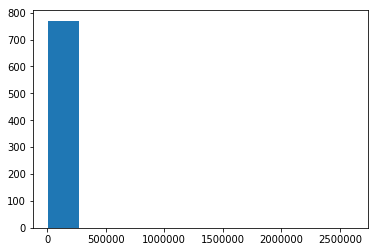

In [96]:
plt.hist([x for x in pupil_area if x >10000])


In [87]:
print(stat.median(pupil_area))
print(stat.mean(pupil_area))
print(max(pupil_area))
print(min(pupil_area))

2302.909816470982
2957.513175043118
2609022.1915346375
0


In [56]:
cv2.destroyAllWindows()